# VGG

In [ ]:
from torchvision import transforms, datasets
import json
import os
import torch.nn as nn
import torch.optim as optim
import torch

## VGG架构

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.features = features # 卷积层 & 池化层，用于提取图像特征
        # 三个全连接层
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*7*7, 4096), # 全连接层，输入 512*7*7，输出 4096
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), # 全连接层，输入 4096，输出 4096
            nn.ReLU(True),
            nn.Linear(4096, num_classes) # 最后一层，全连接层，输出类别数
        )
        if init_weights:
            self._initialize_weights() # 调用初始化权重的函数

    def forward(self, x):
        # N x 3 x 224 x 224，输入一个批次的图像
        x = self.features(x) # 通过卷积层提取特征
        # N x 512 x 7 x 7，经过所有卷积层后的图像
        x = torch.flatten(x, start_dim=1) # 将输出展平成一维，并去掉批次维度
        # N x 512*7*7，展平后的形状，准备送入全连接层
        x = self.classifier(x) # 通过全连接层进行分类
        return x # 返回分类结果

    # 权重初始化
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # 卷积层
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight) # Xavier 均匀初始化卷积层权重
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear): # 全连接层
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## 特征提取层的构建
使用make_features函数按照配置文件中各个VGG网络所含有的卷积层 & 池化层层数及分布，沿着深度一层层地进行初始化

In [ ]:
def make_features(cfg: list):
    layers = []  # 存储层的列表
    in_channels = 3  # 输入的RGB图像通道数为 3
    for v in cfg:  # 遍历配置文件
        if v == "M":  # 如果是最大池化层
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]  # 添加 2x2 最大池化层，步长为 2
        else:  # 如果是卷积层
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)  # 创建 3x3 卷积层，padding=1 保持图像大小
            layers += [conv2d, nn.ReLU(True)]  # 卷积层后面跟着 ReLU 激活函数
            in_channels = v  # 更新输入通道数为当前卷积层的输出通道数
    return nn.Sequential(*layers)  # 将所有层组合成一个顺序容器，按照非关键字参数的格式进行传参（使用关键字参数也可以）

## 配置文件

In [ ]:
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],  # vgg11 配置
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],  # vgg13 配置
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],  # vgg16 配置
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],  # vgg19 配置
}

## 模型创建函数
按照传入的模型名称，根据对应的卷积层配置对网络结构进行初始化

In [ ]:
def vgg(model_name="vgg16", **kwargs):
    try:
        cfg = cfgs[model_name]  # 根据模型名称获取对应的配置
    except:
        print("Warning: model number {} not in cfgs dict!".format(model_name))
        exit(-1)
    model = VGG(make_features(cfg), **kwargs)  # 使用配置创建卷积层 & 池化层，并初始化 VGG 模型，可变参数代表：num_classes & init_weights
    return model

# Train

In [ ]:
# 设置设备为 GPU (cuda:0) 如果有可用 GPU，否则使用 CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # 打印当前使用的设备

cuda:0


定义数据预处理方式，分别为训练集和验证集设置不同的预处理方法

In [ ]:
data_transform = {
    "train": transforms.Compose([  # 训练集的数据预处理方式
        transforms.RandomResizedCrop(224),  # 随机裁剪图像并缩放到 224x224
        transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
        transforms.ToTensor(),  # 将图像转换为 Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化，均值和标准差均为 0.5
    ]),
    "val": transforms.Compose([  # 验证集的数据预处理方式
        transforms.Resize((224, 224)),  # 调整图像大小为 224x224
        transforms.ToTensor(),  # 将图像转换为 Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
    ])
}

获取数据

In [ ]:
# 定义花卉数据集的路径
image_path = '/content/drive/MyDrive/data_set/flower_data/'

训练集

In [ ]:
# 创建训练集的数据集对象，并指定数据预处理方式
train_dataset = datasets.ImageFolder(root=image_path+"train", transform=data_transform["train"])
train_num = len(train_dataset)  # 计算训练集的样本数

# 获取类与索引的映射 {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflower': 3, 'tulips': 4}
flower_list = train_dataset.class_to_idx
# 生成索引到类别的映射
cla_dict = dict((val, key) for key, val in flower_list.items())
# 将映射写入到一个 JSON 文件中，以便保存和加载
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)  # 将 JSON 字符串写入文件

# 设置批次大小
batch_size = 8
# 使用 DataLoader 加载训练数据集，shuffle=True 使得每个 epoch 随机打乱数据，没有多线程
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

验证集

In [ ]:
# 创建验证集的数据集对象，并指定数据预处理方式
validate_dataset = datasets.ImageFolder(root=image_path + "val", transform=data_transform["val"])
val_num = len(validate_dataset)  # 计算验证集的样本数
# 使用 DataLoader 加载验证数据集，shuffle=False 表示不打乱数据，没有多线程
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

创建 VGG16 模型实例，指定类别数为 6，并初始化权重

In [ ]:
model_name = "vgg16"
net = vgg(model_name=model_name, num_classes=6, init_weights=True)
# 将模型移动到指定设备（GPU 或 CPU）
net.to(device)
# 定义损失函数，使用多类别交叉熵损失
loss_function = nn.CrossEntropyLoss()
# 定义优化器，使用 Adam 优化器，优化对象为网络所有可以训练的参数，学习率为 0.0001
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# 初始化最佳精度为 0
best_acc = 0.0
# 定义保存模型的路径
save_path = './{}Net.pth'.format(model_name)

训练30个epoch

In [ ]:
for epoch in range(30):
    net.train() # 训练时启用Dropout
    running_loss = 0.0  # 初始化累计损失
    # 遍历训练集
    for step, data in enumerate(train_loader, start=0):
        images, labels = data  # 获取输入图像和标签
        optimizer.zero_grad()  # 清零梯度
        outputs = net(images.to(device))  # 将图像送入模型并得到预测结果
        loss = loss_function(outputs, labels.to(device)) # 将网络预测的值与真实的标签值进行对比，计算损失梯度
        loss.backward()
        optimizer.step() # 误差的反向传播以及通过优化器对每个结点的参数进行更新

        # 累计损失
        running_loss += loss.item()
        # 打印训练进度
        rate = (step + 1) / len(train_loader)  # 计算当前训练进度
        a = "*" * int(rate * 50)  # 根据进度生成进度条
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")  # 打印当前损失
    print()

    # 进入评估模式
    net.eval() # 验证时关闭Dropout
    acc = 0.0  # 初始化准确率
    with torch.no_grad():  # 不需要计算梯度
        # 遍历验证集
        for val_data in validate_loader:
            val_images, val_labels = val_data  # 获取验证集图像和标签
            optimizer.zero_grad()  # 清零梯度
            outputs = net(val_images.to(device))  # 通过模型进行预测
            predict_y = torch.max(outputs, dim=1)[1]  # 选择概率最大的类别
            acc += (predict_y == val_labels.to(device)).sum().item()  # 计算正确预测的数量

        # 计算验证集的准确率
        val_accurate = acc / val_num
        # 如果当前准确率超过历史的最佳准确率，将当前值赋值给最优，并且保存当前的权重
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        # 打印当前 epoch 的训练损失和验证集准确率
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' % (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')

train loss: 100%[**************************************************->]1.847
[epoch 1] train_loss: 1.608  test_accuracy: 0.346
train loss: 100%[**************************************************->]1.245
[epoch 2] train_loss: 1.434  test_accuracy: 0.434
train loss: 100%[**************************************************->]0.604
[epoch 3] train_loss: 1.166  test_accuracy: 0.624
train loss: 100%[**************************************************->]1.519
[epoch 4] train_loss: 1.059  test_accuracy: 0.588
train loss: 100%[**************************************************->]1.068
[epoch 5] train_loss: 1.016  test_accuracy: 0.676
train loss: 100%[**************************************************->]0.675
[epoch 6] train_loss: 0.993  test_accuracy: 0.602
train loss: 100%[**************************************************->]0.723
[epoch 7] train_loss: 0.968  test_accuracy: 0.668
train loss: 100%[**************************************************->]0.499
[epoch 8] train_loss: 0.953  test_accuracy

# Test

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

ransforms.Compose
数据预处理

transforms.Resize((224, 224))
将图片缩放到224*224

transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
转化为Tensor并进行标准化

In [ ]:
data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

加载图片，对图片进行预处理，并且在最前面添加新的batch维度

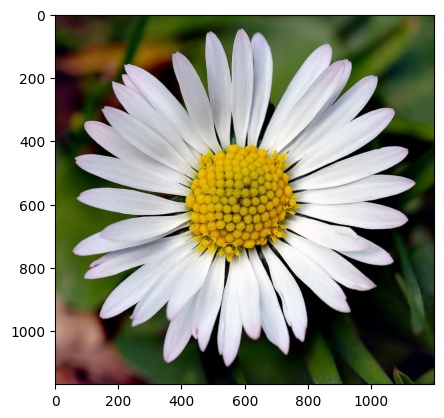

In [ ]:
img = Image.open("/content/drive/MyDrive/data_set/test_data/1.jpg")
plt.imshow(img)

# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

读取json文件中对应的类别名称，载入之后对其进行解码成我们所需要的字典

In [ ]:
try:
    json_file = open('./class_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

使用训练好的模型进行预测

In [ ]:
# 初始化模型
model = vgg(model_name="vgg16", num_classes=6)
# 加载权重
model_weight_path = "./vgg16Net.pth"
# 加载模型
model.load_state_dict(torch.load(model_weight_path))
# 关闭Dropout
model.eval()

with torch.no_grad():
    output = torch.squeeze(model(img))
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()
print(class_indict[str(predict_cla)],predict[predict_cla].numpy())
plt.show()

<ipython-input-28-33728f2883a7>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_path))


daisy 0.9999957
